# Simple Stellar Population (SSP) Feedback with SYGMA

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from NuPyCEE import sygma
from NuPyCEE import omega
from NuPyCEE import nupy_path
import fsps

yield_dir = nupy_path + 'yield_tables/'

### Define functions for this notebook

In [2]:
%run notebook_functions.py

### Set parameters for SYGMA

In [3]:
# Parameter dictionary
params = dict()

# AGB and massive stars yields
params["table"] = yield_dir+'agb_and_massive_stars_K10_LC18_Ravg.txt'
params["imf_yields_range"] = [1.0, 100.0] # [Msun] - Stars in that mass range will eject metals

# Transition mass between AGB and massive star yields
# !!! --> CC SNe will be counted from the transition mass up to imf_yields_range[1]
params["transitionmass"] = 8.0 # [Msun]

# Type of IMF - can be a custom one
params["imf_type"] = 'chabrier'
params["imf_bdys"] = [0.1, 100] # [Msun] - Lower and upper limit of the IMF

# Mass of the stellar population [Msun]
params["mgal"] = 1.0

# SNe Ia
params["sn1a_table"] = yield_dir+'sn1a_i99_W7.txt'
params["nb_1a_per_m"] = 1.0e-3 # Number of SN Ia per units of Msun formed
params["sn1a_rate"] = 'power_law' # Shape (delay-time distribution) of the SN Ia rate
params["beta_pow"] = -1.0 # Slope of the power law (SN Ia rate)

# Neutron star mergers (NSMs)
params["ns_merger_on"] = True
params["nsmerger_table"] = yield_dir+'r_process_arnould_2007.txt' # r-process table (based on the solar composition)
params["nsm_dtd_power"] = [3.0e7, 1.0e10, -1.0] # Shape of the NSM rate, t^-1 from 30 Myr to 10 Gyr
params["nb_nsm_per_m"] = 1.5e-5 # Number of NSM per units of Msun formed
params["m_ej_nsm"] = 1.0e-2 # Mass ejected by each NSM 

# Timestep of the output
params["dt"] = 1.0e6
params["special_timesteps"] = 100 # Logarithmic timesteping
# See more timestep options here: 
# https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb

### Set parameters for FSPS
http://dfm.io/python-fsps/current/stellarpop_api/

In [4]:
# There should only ever be one StellarPopulation instance!
sp = fsps.StellarPopulation(zcontinuous=1, # specify single metallicity
                            sfh=0)         # compute an SSP; i.e., no SF hist
                                           # SF is always normalized to 1

In [11]:
sp.params['zred'] = 0.0

# IMF - can still be custom
sp.params['imf_type'] = 1 # Chabrier
sp.params['imf_lower_limit'] = params['imf_bdys'][0]
sp.params['imf_upper_limit'] = params['imf_bdys'][1]

# Major feature toggles
sp.params['add_neb_emission'] = False  # from Cloudy
sp.params['add_neb_continuum'] = False # off if neb emis is False
sp.params['nebemlineinspec'] = False   # incl emission fluxes in spectra

sp.params['add_agb_dust_model'] = True  # scaled by agb_dust
sp.params['add_dust_emission'] = False  # Draine & Li 2007; for CSPs
sp.params['cloudy_dust'] = False        # incl dust in Cloudy tables

sp.params['add_stellar_remnants'] = True # incl remnants in stellar mass calc

# Add stellar velocity dispersion or wavelength smoothing; default is none
sp.params['smooth_velocity'] = True # False smooths in wavelength space
sp.params['sigma_smooth'] = 0.0     # if smooth_velocity, dispersion in km/s

print('Isochrone & Spectral libraries:', sp.libraries,
      '(can only be changed by recompiling FSPS)')

Isochrone library: (b'mist', b'miles') (can only be changed by recompiling FSPS)


### Extract the list of available metallicities

In [6]:
# Run a dummy chemical evolution calculation to access the table info
o_dummy = omega.omega(table=params["table"])
Z_table = o_dummy.Z_table
nb_Z = len(Z_table)

# Print the metallicities
print("\nAvailable metallicities (Z, mass fraction)")
print("  ",Z_table)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.88s

Available metallicities (Z, mass fraction)
   [0.02, 0.01345, 0.008, 0.004, 0.003236, 0.0003236, 0.0001, 3.236e-05]


### Run SYGMA for all available metallicities

In [7]:
sygma_instances = []
for Z in Z_table:
    sygma_instances.append(sygma.sygma(iniZ=Z, **params))

SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.14s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.14s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.14s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.16s


### Run FSPS for all available metallicities

In [28]:
fsps_outputs = []
Z_sol = 0.01295 # consistent with the grackle CLOUDY tables
for Z in Z_table:
    sp.params['logzsol'] = np.log10(Z/Z_sol)
    
wave, spec = sp.get_spectrum(peraa=True)

In [29]:
wave.shape, spec.shape, sp.log_age.shape

((5994,), (107, 5994), (107,))

Text(0, 0.5, 'log(sum(spectra))')

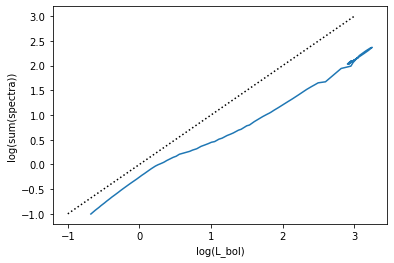

In [30]:
plt.plot(sp.log_lbol, np.log10(spec.sum(axis=1)))
plt.plot(np.linspace(-1,3), np.linspace(-1,3), 'k:')
plt.xlabel('log(L_bol)')
plt.ylabel('log(sum(spectra))')

### Write feedback table

In [10]:
# Choose your elements and output file name
elements = ['H', 'He', 'C', 'O', 'Ne', 'Mg', 'Si', 'S', 'Fe', 'Eu', 'Ba']

# Choose the kinetic energy released by sources [erg]
e_per_CC_SN = 1.0e51
e_per_SN_Ia = 1.0e51

# Define the credits for generating the table
prepared_by = "your_name"

# Name the table
table_name = "your_table"

# Open the table
enzo_table = open("output_tables/"+table_name+".txt", "w")

# Write the file header
write_main_header(enzo_table, prepared_by, params)

# For each metallicity 
for i_Z in range(nb_Z):

    # Copy the instance
    inst = sygma_instances[i_Z]
    
    # Write the metallicity and column labels
    write_metallicity_header(enzo_table, inst, elements)
    
    # For each timestep ..
    for i_t in range(inst.nb_timesteps):
        
        # Get the stellar ejecta rate [Msun/yr]
        r_ej_elements, r_ej_tot, r_ej_Z = get_ejecta_rate(inst, i_t, elements)

        # Get the kinetic energy rate [erg/s]
        r_e_CC_SN, r_e_SN_Ia = get_energy_rate(inst, i_t, e_per_CC_SN, e_per_SN_Ia)
        
        # Write time [yr]
        enzo_table.write(fill_with_space('%.4e'%inst.history.age[i_t]))
        
        # Write the mass ejection rates [Msun/yr]
        for i_elem in range(len(r_ej_elements)):
            enzo_table.write(fill_with_space('%.4e'%r_ej_elements[i_elem]))
        enzo_table.write(fill_with_space('%.4e'%r_ej_tot))
        enzo_table.write(fill_with_space('%.4e'%r_ej_Z))
        
        # Write energy rate [erg/s]
        enzo_table.write(fill_with_space('%.4e'%r_e_CC_SN))
        enzo_table.write(fill_with_space('%.4e'%r_e_SN_Ia))
        
        # Prepare for the next time entry
        enzo_table.write("\n")
        
# Close the table
enzo_table.close()